# Гауссовские процессы #

На этом занятии рассматриваются некоторые концепции гауссовских процессов, такие как стохастические процессы и функция ядра. Мы будем углублять понимание того, как реализовать регрессию с помощью гауссовских процессов &laquo;с нуля&raquo;.

Предполагается, что студент знаком с основами теории вероятности и линейной алгебры, особенно в контексте многомерных гауссовых распределений.

## Список обозначений ##

$(\Omega, \mathcal{F}, \mathbb{P})$ &mdash; вероятностное пространство ($\Omega$ &mdash; множество исходов, $\mathcal{F}$ &mdash; $\sigma$-алгебра, $\mathbb{P}$ &mdash; вероятностная мера)

$\mathbb{E}X$, $\mathbb{E}(X)$ &mdash; математическое ожидание случайной величины $X$

$\mathbb{D}X$, $\mathbb{D}(X)$ &mdash; дисперсия случайной величины $X$

$\mathrm{cov}(X, Y)$ &mdash; корреляционный момент случайных величин $X$ и $Y$


In [14]:
# Imports
import sys
import numpy as np
import scipy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

In [13]:
# Styles, fonts
sns.set_style('whitegrid')
matplotlib.rcParams['font.size'] = 12

---

## Случайные процессы ##

Что такое гауссовский процесс?
Как можно догадаться из названия, это процесс, состоящий из случайных величин, распределённых по Гауссу.
Точное определение гласит, что гауссовский процесс &mdash; это процесс, все конечномерные распределения которого гауссовские.
Данное определение (хотя оно и абсолютно верное) всё же не до конца проясняет ситуацию.
Поэтому давайте копнём немного глубже.

### Базовые понятия и определения ###

Вначале теория веротяностей имела дело со *случайными экспериментами* (подбрасывание монеты, игральной кости и т.п.), для которых подсчитывались вероятности, в которыми может произойти то или иное событие.
Затем возникло понятие *случайной величины*, позволившее количественно описывать результаты проводимых экспериментов, например, размер выигрыша в лотерее.
Наконец, в случайные эксперименты был явно введён *фактор времени*, что дало возможность строить *стохастические модели*, в основу которых легло понятие *случайного процесса*, описывающего динамику развития изучаемого случайного явления.

Случайные (или стохастические) процессы обычно описывают системы, случайно меняющиеся с течением времени. Процессы являются стохастическими из-за наличия в системе неопределённости. Даже если исходная точка известна, существует несколько направлений, в которых такие процессы могут развиваться.

**Определение 1.** *Случайным процессом* называется семейство случайных величин $X(\omega, t)$, $\omega \in \Omega$, заданных на одном вероятностном пространстве $(\Omega, \mathcal{F}, \mathbb{P})$ и зависящих от параметра $t$, принимающего значения из некоторого множества $T \in \mathbb{R}$. Параметр $t$ обычно называют *временем*.

К случайному процессу всегда следует относиться как к функции двух переменных: исхода $\omega$ и времени $t$. Это независимые переменные.

**Определение 2.** При фиксированном времени $t = t_0$ случайная величина $X(\omega, t_0)$ называется *сечением процесса* в точке $t_0$. При фиксированном исходе $\omega = \omega_0$ функция времени $X(\omega_0, t)$ называется *траекторией* (*реализацией*, *выборочной функцией*) процесса.

### Пример ###

Известным примером стохастического процесса является модель броуновского движения (известная также как Винеровский процесс).
Броуновское движение &mdash; это случайное движение частиц, взвешенных в жидкости.
Такое движение может рассматриваться как непрерывное случайное движение, при котором частица перемещается в жидкости из-за случайного столкновения с ней других частиц.
Мы можем моделировать этот процесс во времени $t$ в одном измерении $d$, начиная с точки $0$ и перемещая частицу за определенное количество времени $\Delta t$ на случайное расстояние $\Delta d$ от предыдущего положения.
Случайное расстояние выбирается из нормального распределения со средним $0$ и дисперсией $\Delta t$. Выборку $\Delta d$ из этого нормального распределения обозначим как $\Delta d \sim \mathcal{N}(0, \Delta t)$. Позицию $d(t)$ изменяется со временем по следующему закону $d(t + \Delta t) = d(t) + \Delta d$.

На следующем рисунке мы смоделировали 10 различных траекторий броуновского движения, каждый из которых проиллюстрирован разным цветом.

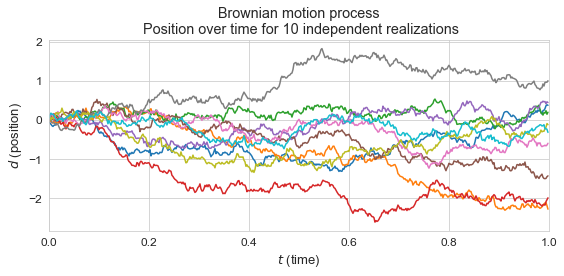

In [4]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 500
delta_t = total_time / nb_steps
nb_processes = 10  # Simulate 10 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively making a new movement delta_d
# Move randomly from current location to N(0, delta_t)
distances = np.cumsum(np.random.normal(mean, stdev, (nb_processes, nb_steps)), axis=1)

plt.figure(figsize=(8, 4))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title(('Brownian motion process\n '
           'Position over time for 10 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()

### Моментные характеристики процессов ###

На рисунке выше можно видеть несколько траекторий стохастического процесса.  Каждая реализация определяет позицию $d$ для каждого возможного временного шага $t$. Таким образом, каждая реализация соответствует функции $f(t) = d$.

Это означает, что случайный процесс можно интерпретировать как случайное распределение функции. Мы можем получить реализацию функции с помощью стохастического процесса. Однако каждая реализация функции будет различной из-за случайности стохастического процесса.

**Определение 3.** *Математическим ожиданием* случайного процесса $X(t)$ называется функция $m_x : T \rightarrow \mathbb{R}$, значение который в каждый момент времени равно математическому ожиданию соответствующего сечения, т.е. $\forall t \in T \; m_x(t) = \mathbb{E}X(t)$.

**Определение 4.** *Корреляционной функцией* случайного процесса $X(t)$ называется функция двух переменных $K_x : T \times T \rightarrow \mathbb{R}$, которая каждой паре моментов времени сопоставляет корреляционный момент соответствующих сечений процесса, т.е.
$$
    K_x(t_1, t_2) = \mathbb{E} \left[ \left(X(t_1) - \mathbb{E}X(t_1)\right) \cdot \left(X(t_2) - \mathbb{E}X(t_2)\right) \right].
$$

---

## Гауссовские процессы

### Базовые понятия и определения ###

**Определение 5.** Случайный процесс $\{X(t), \; t \ge 0\}$ называется *гауссовским*, если для любого $n \ge 1$ и точек $0 \le t_1 < \ldots < t_n$ вектор $(X(t_1), \, \ldots \,, X(t_n))$ является нормальным случайным вектором.

Гауссовский процесс &mdash; это процесс, все конечномерные распределения которого нормальные (гауссовские). Это значит, что любой случайный вектор, составленный из сечений такого процесса, имеет нормальное распределение.


Гауссовские процессы &mdash; это распределение функций $f(x)$, которое определяется средней функцией $m(t)$ и положительной ковариационной функцией $k(t,t')$, где $t$ &mdash; параметр функции, а $(t,t')$ &mdash; все возможные пары из области определения. Обозначаются гауссовские процессы так:

$$ f(t) \sim \mathcal{GP}(m(t), k(t,t')). $$

Для любого конечного подмножества $T=\{{t}_1 \ldots {t}_n \}$ области определения $t$ распределение $f(T)$ представляет собой многомерное гауссовское распределение

$$ f(T) \sim \mathcal{N}(m(T), k(T, T)) $$

со средним вектором $\mathbf{\mu} = m(T)$ и ковариационной матрицей $\Sigma = k(T, T)$.

В то время как многомерное гауссовское  распределение задаёт конечное количество совместно распределённых по Гауссу величин, гауссовский процесс не имеет этого ограничения.
Его среднее и ковариация определяются функциями.
Каждый вход в эту функцию является переменной, коррелирующей с другими переменными входного домена в соотвествии с ковариационной функцией.
Поскольку функции могут иметь бесконечный входной домен, гауссовский процесс можно интерпретировать как бесконечную размерную гауссовскую случайную величину.

### Ковариационные функции

Гауссовский процесс полноcтью определяется его функцией среднего и ковариационной функцией.
Ковариационная функция $k(x_a, x_b)$ моделирует совместную изменчивость случайных переменных гауссовского процесса, она возвращает значение ковариации между каждой парой в $x_a$ и $x_b$.

The specification of this covariance function, also known as the kernel function, implies a distribution over functions $f(x)$. By choosing a specific kernel function $k$ it is possible to set [prior](https://en.wikipedia.org/wiki/Prior_probability) information on this distribution. This kernel function needs to be [positive-definite](https://en.wikipedia.org/wiki/Positive-definite_function) in order to be a valid covariance function.

Спецификация этой ковариационной функции (также известной как функция ядра) предполагает распределение по функциям $f(x)$. Выбирая конкретную функцию ядра $k$, можно задать предварительную информацию о данном распределении. Чтобы быть ковариационной функция ядра должна быть симметричной и положительно-определённой.

Мы будем использовать квадратичную экспоненциальтную ковариационную функцию (также известную как гауссовская ядерная функция):

$$ k(x_a, x_b) = \exp{ \left( -\frac{1}{2\sigma^2} \lVert x_a - x_b \rVert^2 \right) } $$

Могут быть определены и другие функции ядра, приводящие к различным свойствам распределения гауссовского процесса.

In [6]:
# Isotropic squared exponential kernel.
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    Isotropic squared exponential kernel. Computes 
    a covariance matrix from points in X1 and X2.
    
    Args:
        X1: Array of m points (m x d).
        X2: Array of n points (n x d).

    Returns:
        Covariance matrix (m x n).
    '''
    
    sqdist = np.sum(X1**2,1).reshape(-1,1) + np.sum(X2**2,1) - 2*np.dot(X1, X2.T)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sqdist)

Пример ковариационной матрицы из экспонентированной квадратичной ковариационной функции приведен на рисунке слева внизу. Справа показана ковариация против входного нуля. Обратите внимание, что ковариационная функция уменьшается экспоненциально, с ростом  $x$.

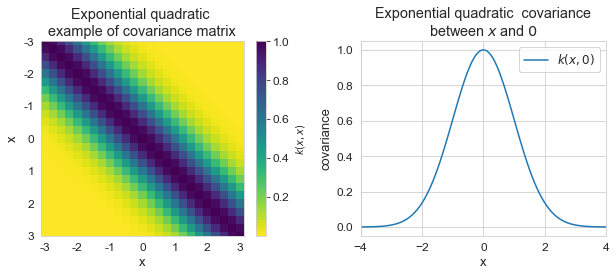

In [7]:
# Illustrate covariance matrix and function

# Show covariance matrix example from exponentiated quadratic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4))
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Sigma = kernel(X, X)
# Plot covariance matrix
im = ax1.imshow(Sigma, cmap=cm.viridis_r)
cbar = plt.colorbar(
    im, ax=ax1, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
ax1.set_title((
    'Exponential quadratic \n'
    'example of covariance matrix'))
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('x', fontsize=13)
ticks = list(range(xlim[0], xlim[1]+1))
ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_xticklabels(ticks)
ax1.set_yticklabels(ticks)
ax1.grid(False)

# Show covariance with X=0
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=100), 1)
zero = np.array([[0]])
Sigma_0 = kernel(X, zero)
# Make the plots
ax2.plot(X[:,0], Sigma_0[:,0], label='$k(x,0)$')
ax2.set_xlabel('x', fontsize=13)
ax2.set_ylabel('covariance', fontsize=13)
ax2.set_title((
    'Exponential quadratic  covariance\n'
    'between $x$ and $0$'))
# ax2.set_ylim([0, 1.1])
ax2.set_xlim(*xlim)
ax2.legend(loc=1)

fig.tight_layout()
plt.show()
#

### Генерация случайной выборки гауссовских процессов ###

На практике мы не можем просто взять пример полной функциональной оценки $f$ из распределения гауссовского процесса, так как это означает оценку $m(x)$ и $k(x,x')$ в бесконечном количестве точек, поскольку $x$ может иметь бесконечный домен.
Однако мы можем привести пример оценки функции $\mathbf{y}$ функции $f$, взятой из гаусского процесса, по конечному, но произвольному набору точек $X$: $\mathbf{y} = f(X)$.

Конечное размерное подмножество распределения гауссовского процесса приводит к частному распределению, которое является гауссовским распределением $\mathbf{y} \sim \mathcal{N}(\mathbf{\mu}, \Sigma)$ со средним вектором $\mathbf{\mu} = m(X)$ и ковариационной матрицей $\Sigma = k(X, X)$.

На рисунке ниже приведена выборка из 5 различных функциональных реализаций гауссовского процесса с экспоненцированным квадратичным ядром без каких-либо наблюдаемых данных.
Для этого мы нарисуем коррелированные образцы из 41-мерного гауссианы $\mathcal{N}(0, k(X, X))$ с $X = [X_1, \ldots, X_{41}]$.

In [8]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(0, 8, nb_of_samples), 1)
Sigma = kernel(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Sigma, size=number_of_functions)

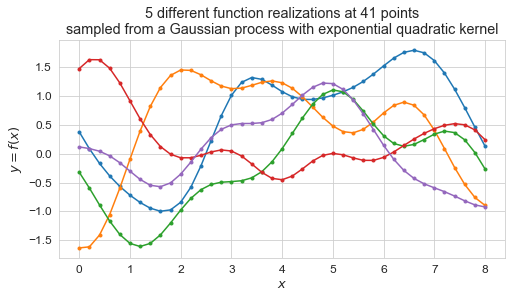

In [9]:
# Plot the sampled functions
plt.figure(figsize=(8, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title(
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponential quadratic kernel')
# plt.xlim([0, 8])
plt.show()
#

Другой способ визуализировать это &mdash; взять только 2 измерения 41-мерной функции Гаусса и нарисовать некоторые его 2D частные распределения.

Следующий рисунок слева визуализирует 2D распределение для $X = [0, 0,2]$, где ковариация $k(0, 0,2) = 0.98$. Рисунок справа визуализирует 2D распределение для $X = [0, 2]$, где ковариация $k(0, 2) = 0.14$.

Для каждого из 2D гауссовых полей соответствующие примеры реализации функций, приведенные выше, представлены на рисунке цветными точками.

Обратите внимание, что точки, близкие друг к другу во входной области $x$, сильно коррелируют ($y_1$ близко к $y_2$), в то время как точки, находящиеся дальше друг от друга, практически независимы. Это связано с тем, что эти поля являются результатом гауссовского процесса с квадратичной ковариацией, которая добавляет предыдущую информацию о том, что точки в области ввода $X$ должны быть близко друг к другу в области вывода $y$.

In [10]:
def generate_surface(mean, covariance):
    """Helper function to generate density surface."""
    nb_of_x = 100 # grid size
    x1s = np.linspace(-5, 5, num=nb_of_x)
    x2s = np.linspace(-5, 5, num=nb_of_x)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((nb_of_x, nb_of_x))
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_x):
        for j in range(nb_of_x):
            pdf[i,j] = scipy.stats.multivariate_normal.pdf(
                np.array([x1[i,j], x2[i,j]]), 
                mean=mean, cov=covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

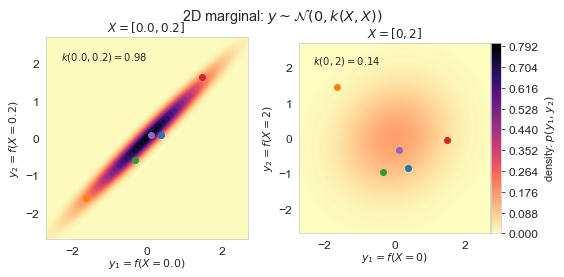

In [15]:
# Show marginal 2D Gaussians

fig = plt.figure(figsize=(8, 4)) 
gs = gridspec.GridSpec(1, 2)
ax_p1 = plt.subplot(gs[0,0])
ax_p2 = plt.subplot(gs[0,1], sharex=ax_p1, sharey=ax_p1)

# Plot of strong correlation
X_strong = np.array([[0], [0.2]])
μ = np.array([0., 0.])
Sigma_strong = kernel(X_strong, X_strong)
y1, y2, p = generate_surface(μ, Sigma_strong)
# Plot bivariate distribution
con1 = ax_p1.contourf(y1, y2, p, 100, cmap=cm.magma_r)
ax_p1.set_xlabel(f'$y_1 = f(X={X_strong[0,0]})$', fontsize=11, labelpad=0)
ax_p1.set_ylabel(f'$y_2 = f(X={X_strong[1,0]})$', fontsize=11)
ax_p1.axis([-2.7, 2.7, -2.7, 2.7])
ax_p1.set_aspect('equal')
ax_p1.text(
    -2.3, 2.1, 
    (f'$k({X_strong[0,0]}, {X_strong[1,0]}) = {Sigma_strong[0,1]:.2f}$'), 
    fontsize=10)
ax_p1.set_title(f'$X = [{X_strong[0,0]}, {X_strong[1,0]}]$ ', fontsize=12)
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_02_index = np.where(np.isclose(X, 0.2))
y_strong = ys[:,[X_0_index[0][0], X_02_index[0][0]]]
# Show samples on surface
for i in range(y_strong.shape[0]):
    ax_p1.plot(y_strong[i,0], y_strong[i,1], marker='o')

# Plot weak correlation
X_weak = np.array([[0], [2]])
μ = np.array([0., 0.])
Sigma_weak = kernel(X_weak, X_weak)
y1, y2, p = generate_surface(μ, Sigma_weak)
# Plot bivariate distribution
con2 = ax_p2.contourf(y1, y2, p, 100, cmap=cm.magma_r)
con2.set_cmap(con1.get_cmap())
con2.set_clim(con1.get_clim())
ax_p2.set_xlabel(f'$y_1 = f(X={X_weak[0,0]})$', fontsize=11, labelpad=0)
ax_p2.set_ylabel(f'$y_2 = f(X={X_weak[1,0]})$', fontsize=11)
ax_p2.set_aspect('equal')
ax_p2.text(
    -2.3, 2.1, 
    (f'$k({X_weak[0,0]}, {X_weak[1,0]}) = {Sigma_weak[0,1]:.2f}$'), 
    fontsize=10)
ax_p2.set_title(
    f'$X = [{X_weak[0,0]}, {X_weak[1,0]}]$', 
    fontsize=12)
# Add colorbar
divider = make_axes_locatable(ax_p2)
cax = divider.append_axes('right', size='5%', pad=0.02)
cbar = plt.colorbar(con1, ax=ax_p2, cax=cax)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=11)
fig.suptitle('2D marginal: $y \sim \mathcal{N}(0, k(X, X))$')
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_2_index = np.where(np.isclose(X, 2.))
y_weak = ys[:,[X_0_index[0][0], X_2_index[0][0]]]
# Show samples on surface
for i in range(y_weak.shape[0]):
    ax_p2.plot(y_weak[i,0], y_weak[i,1], marker='o')

plt.tight_layout()
plt.show()
#

### Ещё примеры ###

In [16]:
def plot_gp(mu, cov, X, X_train=None, Y_train=None, samples=[]):
    X = X.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.figure(figsize=(8,5))
    plt.fill_between(X, mu + uncertainty, mu - uncertainty,
                     color='grey', alpha=0.1, label='95% confidence interval')
    plt.plot(X, samples, '-', lw=1.0)
    plt.plot(X, mu, 'k', label='Mean')
    if X_train is not None:
        plt.plot(X_train, Y_train, 'kx', mew=1.5)
    plt.legend()

In [17]:
# Test data
x_min, x_max = 0, 10
N_test = int(1e3)
X_test = np.linspace(x_min, x_max, N_test).reshape(-1,1)

In [18]:
l = 10e-2*(x_max-x_min)

M = np.zeros_like(X_test).reshape(-1,1)
# M = 5*np.sin(X_test)

K = kernel(X_test, X_test, l=l)
L = np.linalg.cholesky(K + 1e-6*np.eye(N_test))

In [19]:
# Generate samples from the prior
N_gp = 500
gp = M + np.dot(L, np.random.normal(size=(N_test,N_gp)))

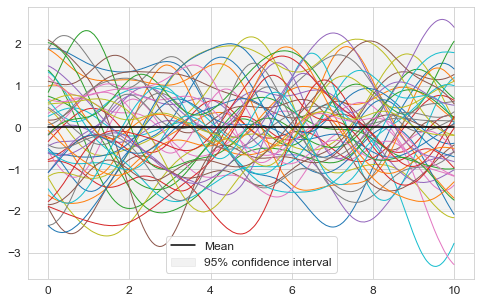

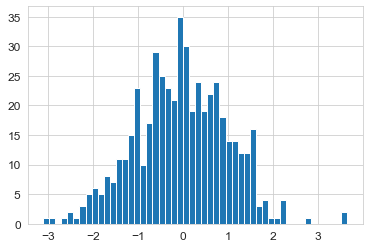

In [20]:
# Draw samples from the prior
plot_gp(M, K, X_test, samples=gp[:,:50])
plt.show()
# Draw section histogram
plt.hist(gp[200], bins=50)
plt.show()

Зачем нам могут понадобиться гауссовские процессы?
Много зачем. Например, можно генерировать процессы, проходящие через определённые точки &mdash; &laquo;прехватывать&raquo; наши процессы в узкие пучки.
Так устроена регрессия на гауссовских процессах.

In [23]:
from numpy.linalg import inv

def posterior_predictive(X_s, X_train, Y_train, l=1.0, sigma_f=1.0, sigma_y=1e-8):
    '''
    Computes the suffifient statistics of the GP posterior predictive distribution 
    from m training data X_train and Y_train and n new inputs X_s.
    
    Args:
        X_s: New input locations (n x d).
        X_train: Training locations (m x d).
        Y_train: Training targets (m x 1).
        l: Kernel length parameter.
        sigma_f: Kernel vertical variation parameter.
        sigma_y: Noise parameter.
    
    Returns:
        Posterior mean vector (n x d) and covariance matrix (n x n).
    '''
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y**2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_s, l, sigma_f)
    K_ss = kernel(X_s, X_s, l, sigma_f) + 1e-8 * np.eye(len(X_s))
    K_inv = inv(K)
    
    # Equation (4)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)

    # Equation (5)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    
    return mu_s, cov_s

In [21]:
X_train = np.array([2.,  6.,  7., 8.,  4. ]).reshape(-1, 1)
Y_train = np.array([1., -1., -1., 0.5, 1.]).reshape(-1, 1)

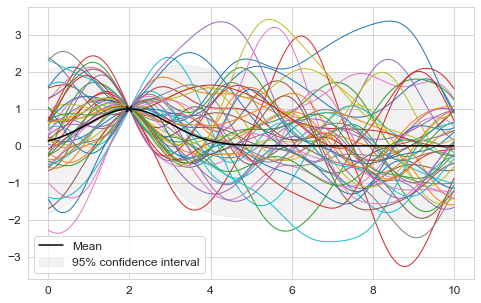

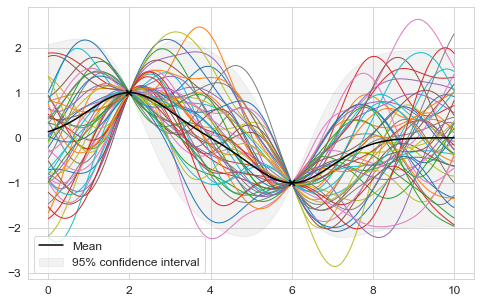

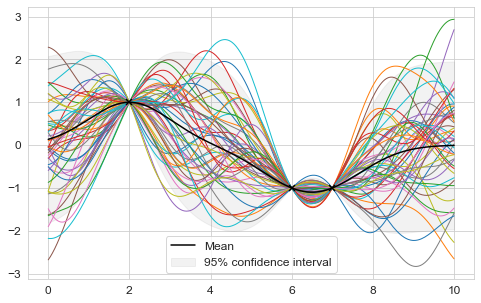

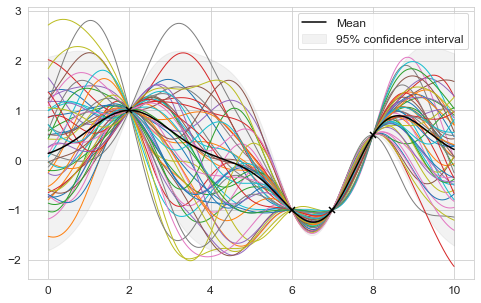

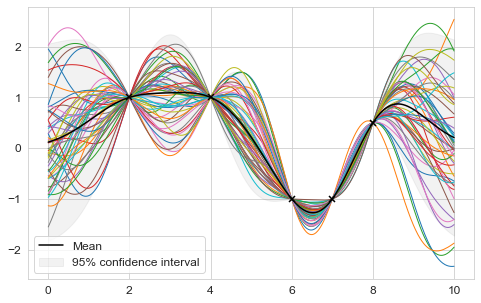

In [24]:
N_gp_post = 50
for i, _ in enumerate(X_train):
    x_train_i = X_train[:i+1]
    y_train_i = Y_train[:i+1]
    
    # Compute mean and covariance of the posterior predictive distribution
    mu_s, cov_s = posterior_predictive(X_test, x_train_i, y_train_i)
    
    # Generate samples from the prior
    gp_post = np.random.multivariate_normal(mu_s.ravel(), cov_s, N_gp_post).T
    
    # Draw samples from the prior
    plot_gp(mu_s, cov_s, X_test, X_train=x_train_i, Y_train=y_train_i, samples=gp_post)

Получим выражения для первых двух кривых в явном виде:

1. $ f(x | x_1, y_1) = y_1 \cdot e^{-\frac{(x-x_1)^2}{2}} = e^{-\frac{(x-2)^2}{2}}$

2. учитывая $ k_{12} = e^{-\frac{(x_2 - x_1)^2}{2}} = e^{-\frac{(6 - 2)^2}{2}} \approx 0 $, получим $ f(x | x_1, y_1, x_2, y_2) \approx y_1 \cdot e^{-\frac{(x-x_1)^2}{2}} + y_2 \cdot e^{-\frac{(x-x_2)^2}{2}} = e^{-\frac{(x-2)^2}{2}} - e^{-\frac{(x-6)^2}{2}} $

## Шумные данные ##

А что, если мы не на 100 % уверены в наших точках? То есть значения, через которые мы проводим процессы, измерены с какой-то точностью. Тогда &laquo;пучки&raquo; можно делать не такими узкими.

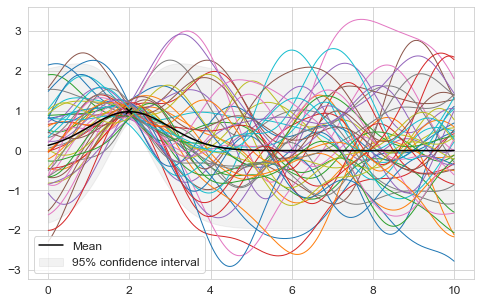

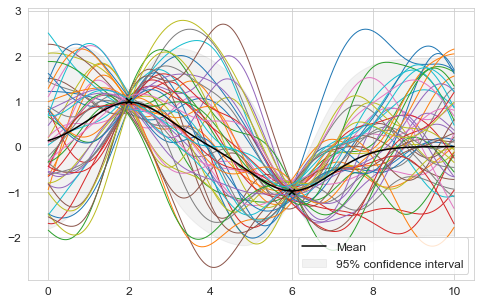

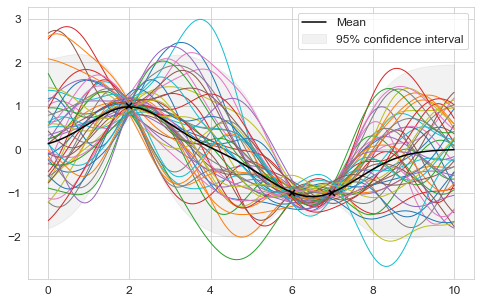

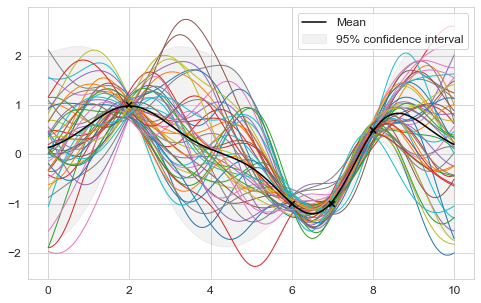

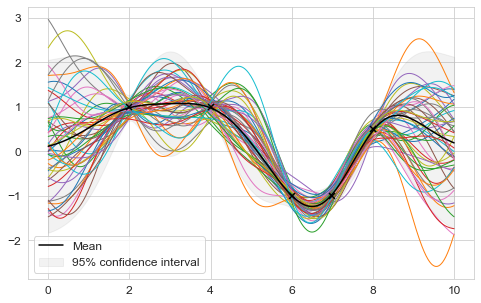

In [91]:
N_gp_post = 50
sigma_y = 0.15
for i, _ in enumerate(X_train):
    x_train_i = X_train[:i+1]
    y_train_i = Y_train[:i+1]
    
    # Compute mean and covariance of the posterior predictive distribution
    mu_s, cov_s = posterior_predictive(X_test, x_train_i, y_train_i, sigma_y=sigma_y)
    
    # Generate samples from the prior
    gp_post = np.random.multivariate_normal(mu_s.ravel(), cov_s, N_gp_post).T
    
    # Draw samples from the prior
    plot_gp(mu_s, cov_s, X_test, X_train=x_train_i, Y_train=y_train_i, samples=gp_post)

## Литература

1. Лекции по случайным процессам / под ред. А.В. Гасникова. М.: МФТИ, 2019
1. Krasser M. JNotebook &laquo;Gaussian_processes.ipynb&raquo;